
Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


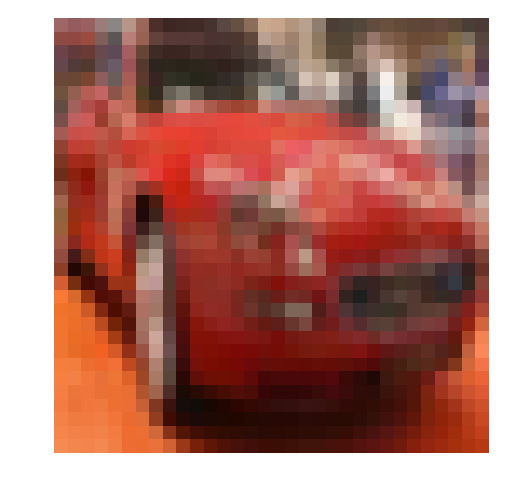

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

cifar10_dataset_folder_path = 'cifar-10-batches-py'
# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [2]:
def normalize(x):
    
    return np.array(x/255.0)


def one_hot_encode(x):

    encoding = np.zeros((len(x),10))
    encoding[np.arange(len(x)),x] = 1
    return encoding


helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)


import pickle
#import problem_unittests as tests
import helper


# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))


In [3]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import rnn
tf.reset_default_graph()

epoches = 10
classes = 10
batch_size = 128
hidden_num = 8
n_batches = 5

#x = tf.placeholder(tf.float32,[None,32,32,3])
x = tf.placeholder(tf.float32,[None,32,32,3])
y = tf.placeholder(tf.float32,[None,classes])

#print(x)
#y = tf.placeholder(tf.float32,[None,classes])
#print(y)
keep_prob = tf.placeholder(tf.float32)

def conv(x,W,strides):
    return tf.nn.conv2d(x,W,strides,padding = 'SAME')

def maxpool(x,ksize,strides):
    return tf.nn.max_pool(x,ksize,strides,padding='SAME' )

def convolutional_neural_network(x,keep_prob):
    weights_conv_1 = tf.Variable(tf.truncated_normal([2,2,3,8], stddev = 0.1))
    weights_conv_2 = tf.Variable(tf.truncated_normal([3,3,8,16], stddev = 0.1))
    weights_conv_3 = tf.Variable(tf.truncated_normal([4,4,16,32], stddev = 0.1))
    weights_full = tf.Variable(tf.truncated_normal([4*4*32, 1024], stddev = 0.1))
    #weights_full = tf.Variable(tf.truncated_normal([hidden_num, 1024], stddev = 0.1))
    weights_out = tf.Variable(tf.random_normal([1024,classes], stddev = 0.1))
    
    bias_conv_1 = tf.Variable(tf.zeros([8]))
    bias_conv_2 = tf.Variable(tf.zeros([16]))
    bias_conv_3 = tf.Variable(tf.zeros([32]))
    bias_full = tf.Variable(tf.zeros([1024]))
    bias_out = tf.Variable(tf.zeros([classes]))

    x = tf.reshape(x, shape = [-1,32,32,3])
    conv_1 = conv(x,weights_conv_1,[1,1,1,1])
    conv_1 = maxpool(conv_1,[1,2,2,1],[1,2,2,1])
    #print(conv_1.shape)

    conv_2 = conv(conv_1,weights_conv_2,[1,1,1,1])
    conv_2 = maxpool(conv_2,[1,2,2,1],[1,2,2,1])
    #print(conv_2.shape)
    
    conv_3 = conv(conv_2,weights_conv_3,[1,1,1,1])
    conv_3 = maxpool(conv_3,[1,2,2,1],[1,2,2,1])
    print(conv_3)
    
    
    dim = conv_3.get_shape().as_list()
    #print(dim)
    conv_f = tf.reshape(conv_3,[-1,dim[1]*dim[2]*dim[3]])
    #print(conv_f.shape)
    conv_f = tf.nn.relu(tf.matmul(conv_f,weights_full) + bias_full)
    conv_f = tf.nn.relu(conv_f)
    conv_f = tf.nn.dropout(conv_f,keep_prob)
    #print(conv_f.shape)

    conv_o = tf.nn.relu(tf.matmul(conv_f,weights_out) + bias_out)
    conv_o = tf.nn.dropout(conv_o,keep_prob)
    #print(conv_o.shape)
    return conv_o,conv_3

In [4]:
r_x = tf.placeholder(tf.float32,[None,4,4,32])
r_keep_prob = tf.placeholder(tf.float32)

r_y = tf.placeholder(tf.float32,[None,10])


def recurrent_neural_network(r_x,r_keep_prob):    
    dim = r_x.get_shape().as_list()
    print(dim)
    recurrent_input = tf.reshape(r_x,[-1,dim[1],dim[2]*dim[3]])
    #recurrent_input = tf.reshape(x,[128,4,128])
    
    weights_full = tf.Variable(tf.truncated_normal([hidden_num, 1024], stddev = 0.1))
    bias_full = tf.Variable(tf.zeros([1024]))

    weights_out = tf.Variable(tf.random_normal([1024,classes], stddev = 0.1))
    bias_out = tf.Variable(tf.zeros([classes]))
    
    data = tf.transpose(recurrent_input,[0,2,1])
    cell = rnn.LSTMCell(hidden_num,state_is_tuple = True)
    cell = rnn.DropoutWrapper(cell,r_keep_prob)
    value, state = tf.nn.dynamic_rnn(cell,data,dtype = tf.float32)
    value = tf.transpose(value,[1,0,2])
    last_val = tf.gather(value, int(value.get_shape()[0]) - 1)
    
    recc_f = tf.nn.relu(tf.matmul(last_val,weights_full) + bias_full)
    
    recc_o = tf.nn.relu(tf.matmul(recc_f,weights_out) + bias_out)

    return recc_o

In [ ]:
def train(x,keep_prob):
    prediction,features = convolutional_neural_network(x,keep_prob)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = prediction,labels = y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    featureset = []
    #featureset_valid = []

    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        tf.set_random_seed(1000)

        for epoch in range(epoches):
            loss = 0
            n_batches = 5
            #for _ in range(int(mnist.train.num_examples/batch_size)):
            #for batch_i in range(1, n_batches+1):

            for batch_i in range(1, n_batches+1):
                for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                    #epoch_x = epoch_x.reshape((batch_size,chunks,chunk_size))
                    _,c = sess.run([optimizer,cost],feed_dict = {x: batch_features, y: batch_labels, keep_prob: 0.9})
                    features_n = features.eval({x: batch_features, y: batch_labels, keep_prob: 0.9})
                    
                    features_n = np.array(features_n,dtype=np.float32)
                    
                    featureset.append(features_n)
                    loss += c
            print('Epoch',epoch,'complete out of',epoches,'loss:',loss)
            #print(prediction.shape)
            features_valid = features.eval({x: valid_features, y: valid_labels, keep_prob: 1.0})
            
            correct = tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
            accuracy = tf.reduce_mean(tf.cast(correct,'float'))
            print('Accuracy:',accuracy.eval({x: valid_features, y: valid_labels, keep_prob: 1.0}))
            
            

        print('Accuracy:',accuracy.eval({x: test_features, y: test_labels, keep_prob: 1.0}))
        #featureset = np.array(featureset[-5:])
        return featureset,features_valid

        
c_out,c_valid = train(x,keep_prob)

Tensor("MaxPool_2:0", shape=(?, 4, 4, 32), dtype=float32)
Epoch 0 complete out of 10 loss: 659.474973083
Accuracy: 0.5312
Epoch 1 complete out of 10 loss: 527.733355761
Accuracy: 0.583
Epoch 2 complete out of 10 loss: 479.500790536
Accuracy: 0.6056
Epoch 3 complete out of 10 loss: 450.010113895
Accuracy: 0.6234
Epoch 4 complete out of 10 loss: 422.321885347
Accuracy: 0.6398
Epoch 5 complete out of 10 loss: 397.913194478
Accuracy: 0.6404
Epoch 6 complete out of 10 loss: 374.683700413
Accuracy: 0.6424
Epoch 7 complete out of 10 loss: 358.992618054
Accuracy: 0.6514
Epoch 8 complete out of 10 loss: 339.265804768
Accuracy: 0.651
Epoch 9 complete out of 10 loss: 318.713316381
Accuracy: 0.6556
Accuracy: 0.6463


In [ ]:
def r_train(data,valid_data,r_x,r_keep_prob):
    #data = train(x,keep_prob)
    n_batches = 5
    r_epoches = 15
    r_prediction = recurrent_neural_network(r_x,r_keep_prob)
    
    r_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = r_prediction,labels = r_y))
    r_optimizer = tf.train.AdamOptimizer().minimize(r_cost)
    
    with tf.Session() as r_sess:
        r_sess.run(tf.global_variables_initializer())
        #sess.run(data.eval())
        #data = sess.run(data)
        for epoch in range(r_epoches):
            loss = 0
            i = 0
            #for batch_i in range(1, n_batches + 1):
            for batch_i in range(1, n_batches+1):
                for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):

                    data_in = data[i]
                    _,c = r_sess.run([r_optimizer,r_cost],feed_dict = {r_x: data_in, r_y: batch_labels, r_keep_prob: 0.9})
                    loss += c
                    i += 1
    
            print('Epoch',epoch,'complete out of',epoches,'loss:',loss)
            #print(r_prediction.shape)
            correct = tf.equal(tf.argmax(r_prediction,1),tf.argmax(r_y,1))
            accuracy = tf.reduce_mean(tf.cast(correct,'float'))
            print('Accuracy:',accuracy.eval({r_x: valid_data, r_y: valid_labels, r_keep_prob: 1.0}))    
        
        
r_train(c_out,c_valid,r_x,r_keep_prob)

[None, 4, 4, 32]


/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0 complete out of 10 loss: 803.550757885
Accuracy: 0.1642
Epoch 1 complete out of 10 loss: 804.824974537
Accuracy: 0.1454
Epoch 2 complete out of 10 loss: 801.055309057
Accuracy: 0.1478
Epoch 3 complete out of 10 loss: 799.746410608
Accuracy: 0.1464
Epoch 4 complete out of 10 loss: 797.562066078
Accuracy: 0.144
Epoch 5 complete out of 10 loss: 795.892113924
Accuracy: 0.151
Epoch 6 complete out of 10 loss: 794.068750858
Accuracy: 0.158
Epoch 7 complete out of 10 loss: 785.784734964
Accuracy: 0.182
Epoch 8 complete out of 10 loss: 782.8654809
Accuracy: 0.183
Epoch 9 complete out of 10 loss: 779.712507248
Accuracy: 0.1812
Epoch 10 complete out of 10 loss: 775.076630831
Accuracy: 0.1846
Epoch 11 complete out of 10 loss: 770.954980373
Accuracy: 0.1776
Epoch 12 complete out of 10 loss: 769.149760962
Accuracy: 0.175
Epoch 13 complete out of 10 loss: 767.66845417
Accuracy: 0.1732


In [ ]:
data = train(x,keep_prob)
print(data)
#r_x = tf.placeholder(tf.float32)
#print(r_x)
#r_keep_prob = tf.placeholder(tf.float32)
#print(r_keep_prob)
#r_y = tf.placeholder(tf.float32,[None,10])
n_batches = 5
r_epoches = 5
prediction = recurrent_neural_network(r_x,keep_prob)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = prediction,labels = y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #sess.run(data.eval())
    #data = sess.run(data)
    for epoch in range(r_epoches):
        loss = 0
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                data_in = data[batch_i]
                #TensorArr = tf.TensorArray(tf.float32, 1, dynamic_size=True, infer_shape=False)
                #data_in = TensorArr.unstack(data[batch_i])
                #data[batch_i].set_shape([len(batch_labels),4,4,32])
                #data_in = tf.unstack(data[batch_i])
                #data_in.eval()
                #data_in = tf.TensorArray.read(index = batch_i,name = data)
                #epoch_x = epoch_x.reshape((batch_size,chunks,chunk_size))
                #data_in = tf.unstack(data[batch_i],axis=0)
                data_in = sess.run(data_in)
                _,c = sess.run([optimizer,cost],feed_dict = {r_x: data_in, r_y: batch_labels, r_keep_prob: 0.9})
                loss += c
    
        print('Epoch',epoch,'complete out of',epoches,'loss:',loss)
        print(prediction.shape)
        correct = tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct,'float'))
        print('Accuracy:',accuracy.eval({x: valid_features, y: valid_labels, keep_prob: 1.0}))    